# Case Study 01: Clustering of Doctors' Notes
---

The first case study in the ALADA couse is the problem of clustering medical notes using measures of similarity between vectors. 

We make use of a kaggle dataset for this purpose. The first step to running this notebook is to download the dataset and copy it into the data directory `data/case_study_01/`.

Run the following two cells to import all the necessary libraries and to create the folder for the data files.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pathlib
import re
import polars as pl

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams['svg.fonttype'] = 'none'

import sys
from alada import chap01 as ch01
from alada import casestudy01 as cs01

# Create data folder for the case study
cs01.create_data_folder()

## 0. Getting the data

Link to the kaggle dataset: [https://www.kaggle.com/datasets/gauravmodi/doctors-notes/data](https://www.kaggle.com/datasets/gauravmodi/doctors-notes/data)

Download the `reports.csv` file, and copy it into the folder `data/case_study_01/`. After you have done this, run the following cell and check if it reports success.

In [3]:
cs01.check_dataset()

'Success! You can run this notebook.'

## 1. What does this dataset have?

The data is in a `.csv` file. If you do not know that means, then take a look [here](https://en.wikipedia.org/wiki/Comma-separated_values).

The file has two columns: `medical_specialty` and `report`.
- The `medical_specialty` column contains the specialty of the doctor who wrote the report, and
- the `report` column contains the actual text of the report written down by the doctor for a particular patient.

For the purpose of this case study, we will only be using the `report` column; we will use the `medical_specialty` column only for evaluating the clustering results for us know how well our clustering algorithm has performed.

We have learned about clustering using n-vectors; objects containing numbers. How does one cluster text data? 

We do this by first converting the text data into n-vectors that represent the information contaning in the text. There are many ways to do this, but we will use a simple technique called `count vectorization`.

**Count Vectorization** is a technique that converts text data into n-vectors by counting the number of times a set of `tokens` (chosen words) appears in the text. Tokens are words that are chosen from the text or given by a specialist from the field of study. Consider the following example:

**Text to convert:** "The quick brown fox jumps over the lazy dog. The dog is very lazy, but the fox is quick. The dog is friendly through; the fox cannot be trusted."

**Tokens:** ["quick", "brown", "fox", "lazy", "dog"]

We simply count the number of times each token appears in the text. The vector representation of the text is then: $\begin{bmatrix} 2 & 1 & 3 & 2 & 3 \end{bmatrix}^\top$.

Now, let's read the reports.csv file and see what it has.

In [4]:
# Data folder and file
datadir = "data/case_study_01"
datafile = (datadir / pathlib.Path("reports.csv")).as_posix()
tokensfile = (datadir / pathlib.Path("tokens.txt")).as_posix()

# Read the medical records file.
medrec = pl.read_csv(datafile)

# Let view the first five rows using the .head() function on the polar dataframe.
medrec.head()

medical_specialty,report
str,str
"""Cardiovascular / Pulmonary""","""2-D M-MODE: , ,1. Left atrial…"
"""Cardiovascular / Pulmonary""","""1. The left ventricular cavit…"
"""Cardiovascular / Pulmonary""","""2-D ECHOCARDIOGRAM,Multiple vi…"
"""Cardiovascular / Pulmonary""","""DESCRIPTION:,1. Normal cardia…"
"""Cardiovascular / Pulmonary""","""2-D STUDY,1. Mild aortic steno…"


In [5]:
# Create the medical speciality Enum
medspec_enum = pl.Enum(medrec["medical_specialty"].unique())

# Convert the medical_specialty column to an Enum
medrec = medrec.with_columns(
    medrec["medical_specialty"].cast(medspec_enum)
)

In [6]:
# Let's now count the number of entries we have for each medical speciality.
medrec['medical_specialty'].value_counts()

medical_specialty,count
enum,u32
"""Cardiovascular / Pulmonary""",371
"""Radiology""",273
"""Gastroenterology""",224
"""Surgery""",1088
"""Neurology""",223


---
We see that the text in the `report` column has text with both upper and lower case letters. We will convert all the text to lower case to make it easier to work with; we do not distinguish between 'Cardiology' and 'cardiology'. 

We will, however, not moidfy the `report` column, but create a new column `report_lower` that contains the lower case text.

In [7]:
# Convert a str column in polar to lower case, and it as a new column.
medrec = medrec.with_columns(
    report_lower=pl.col("report").str.to_lowercase()
)
# The first 5 rows in the dataframe
medrec.head()

medical_specialty,report,report_lower
enum,str,str
"""Cardiovascular / Pulmonary""","""2-D M-MODE: , ,1. Left atrial…","""2-d m-mode: , ,1. left atrial…"
"""Cardiovascular / Pulmonary""","""1. The left ventricular cavit…","""1. the left ventricular cavit…"
"""Cardiovascular / Pulmonary""","""2-D ECHOCARDIOGRAM,Multiple vi…","""2-d echocardiogram,multiple vi…"
"""Cardiovascular / Pulmonary""","""DESCRIPTION:,1. Normal cardia…","""description:,1. normal cardia…"
"""Cardiovascular / Pulmonary""","""2-D STUDY,1. Mild aortic steno…","""2-d study,1. mild aortic steno…"


In [8]:
# The last 5 rows in the dataframe
medrec.tail()

medical_specialty,report,report_lower
enum,str,str
"""Cardiovascular / Pulmonary""","""INDICATION: , Chest pain.,TYPE…","""indication: , chest pain.,type…"
"""Cardiovascular / Pulmonary""","""CHIEF COMPLAINT: , Chest pain.…","""chief complaint: , chest pain.…"
"""Cardiovascular / Pulmonary""","""HISTORY OF PRESENT ILLNESS: , …","""history of present illness: , …"
"""Cardiovascular / Pulmonary""","""HISTORY OF PRESENT ILLNESS: , …","""history of present illness: , …"
"""Cardiovascular / Pulmonary""","""REASON FOR CONSULTATION: ,Abn…","""reason for consultation: ,abn…"


---

We can use the lower case text in the `report_lower` column to convert the text into n-vectors for clustering the reports. But **what tokens do we use for this purpose?** 

The file `tokens.txt` in the `data/case_study_01/` folder contains a list of tokens that we will use for this case study. We will not worry about how these tokens were chosen, but use them to convert the text data into n-vectors. This is a text file with each token separated by a comma.

Let's now read this file and look at the tokens.

In [9]:
with open(tokensfile, "r") as f:
    tokens = f.read().split(',')
print("Tokens: ", tokens)
# The number of tokens.
print(f"Number of tokens: {len(tokens):3d}")

Tokens:  ['impress', 'palpitation', 'gallop', 'compare', 'nonsignificant', 'emphysema', 'noncontributory', 'fahrenheit', 'valley', 'recreational', 'collect', 'meckel', 'fundoplication', 'heartburn', 'subjective', 'contributory', 'interpret', 'neutrophil', 'clostridium', 'partners', 'rating', 'psychological', 'huntington', 'epilepsy', 'tended', 'ataxia', 'meningioma', 'command', 'edition', 'america', 'relate', 'sprain', 'cuboid', 'version', 'predict', 'intrinsically', 'discontinuity', 'echogenic', 'subcutis', 'certainty', 'reoperative', 'proximate', 'plication', 'ladder', 'essure', 'ending', 'compress', 'script', 'plasty', 'fluoro']
Number of tokens:  50


---
We can now use these tokens to convert a given text into a n-vectors (25-vector) to be exact. To do this, we will write our own function that takes in a text and the tokens, and returns the n-vector representation of the text. Run the following code so that we can use it in the rest of the notebook.

The following function performs the count vectorization operation.

In [10]:
def count_tokens(note: str, tokens: list) -> np.array:
    """Find the token count in the medical records."""
    return [note.count(tok) for tok in tokens]

---
Let's try this function on some of the reports in the dataset.

In [11]:
for _row in medrec.with_row_index().sample(10).iter_rows(named=True):
    _nvec = count_tokens(_row["report_lower"], tokens)
    print(f"Row: {_row['index']:4d}", _nvec)

Row:  307 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]
Row:  198 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 6, 0, 0, 0, 0, 0, 3, 0]
Row:   89 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0]
Row:  952 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0]
Row:  317 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 1, 0, 0, 1, 0, 0]
Row:   78 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 2, 0, 0, 0, 0, 0, 0, 0]
Row:  780 [0, 0, 0, 0, 0, 0, 0, 0,

## 2. Clustering the reports

Let's now cluster the reports using the n-vector representation of the text. We will then use the `KMeans` algorithm for this purpose.

For the purpose of this case study, we will ignore the surgrey notes and use only those from the other specialities. Following this, we will then generate the n-vectors for each of the reports, which will then be used to cluster the reports.

In [12]:
# Get rid of surgery reports.
medrec_wos = medrec.filter(pl.col("medical_specialty") != "Surgery")

medrec_wos = medrec_wos.with_columns(
    pl.col("report_lower").map_elements(
        lambda note: count_tokens(note, tokens),
        return_dtype=pl.List(pl.Int64)
    ).alias("nvecs")
)

# All n-vectors
tokvec = np.array(medrec_wos["nvecs"].to_list())

In [13]:
# Fit the KMeans model
k = 4
km = ch01.KMeans(X=tokvec, k=k)
cm, ca, j = km.fit(max_iter=25, cost_change_th=0.1, seed=1111)

# Add cluster assignment to the dataframe
medrec_wos = medrec_wos.with_columns(
    pl.Series(ca[-1, :]).alias("cluster")
)

Note that we have set the `seed` value to 1111 in this fitting procedure; this will ensure that the procedure is reproducible. You are encouraged to try different values for the `seed` parameter, and look at the results you get. 

Lets looks at the results of the fitting procedure for the K-means clustering algorithm. We will not plot the cost of the algorithm as a function of the number of iterations.

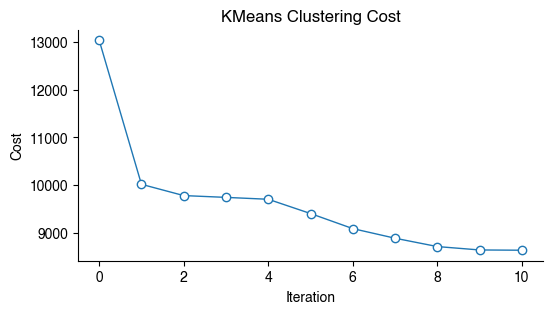

In [14]:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)
ax.plot(np.arange(len(j)), j,  lw=1, marker='o',
        markersize=6, markerfacecolor='white')
ax.set_xlabel("Iteration")
ax.set_ylabel("Cost")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title("KMeans Clustering Cost");

---
Looks like the cost converges very quickly to a value. Since we have the true medical speciality labels, we could cheat and use those to find out how well our clustering approach has done. For each cluster, we count the number of reports that belong to each medical speciality. If we find that each cluster has reports predominantly from a single medical speciality, then we can be confident that we have found a clustering algorithm that captures the underlying structure in our data. If this is not the case, then we might have to looking for more sophisticated approaches for clustering these medical reports.

In [15]:
# Summary dataframe
_medspec = medrec_wos["medical_specialty"].unique().to_list()
summ_dict = {
    "medical_specialty": _medspec
}
# Add cluster columns
for _k in range(k):
    summ_dict[f"clust_{_k}"] = [0] * len(_medspec)
    _clust = medrec_wos.filter(pl.col("cluster") == _k)["medical_specialty"].value_counts()
    for _spec in _clust.iter_rows(named=True):
        summ_dict[f"clust_{_k}"][_medspec.index(_spec["medical_specialty"])] = _spec["count"]
clust_summary = pl.DataFrame(summ_dict)
clust_summary

medical_specialty,clust_0,clust_1,clust_2,clust_3
str,i64,i64,i64,i64
"""Radiology""",254,16,3,0
"""Cardiovascular / Pulmonary""",319,34,0,18
"""Neurology""",193,29,1,0
"""Gastroenterology""",180,23,21,0


The above tables show that counts of the medical specialities in each cluster. It looks like that algorithm has not really done a good job at clustering the reports into their respective medical specialities.

Here are some observations from the clustering results:
1. Most reports appear to be part of cluster 0 which contains almost an equal number of reports from all the medical specialities.
2. Cluster 1 also appears to have an equal number of reports from all four specialities, but the number of reports in this cluster is much smaller than the number of reports in cluster 0.
3. Cluster 2 and cluster 3 appear to be specific to Gasteroenterology and Cardiology/Pulmonary, respectively; note that only a minute number of reports end up in these to clusters (1-2% of the total reports).

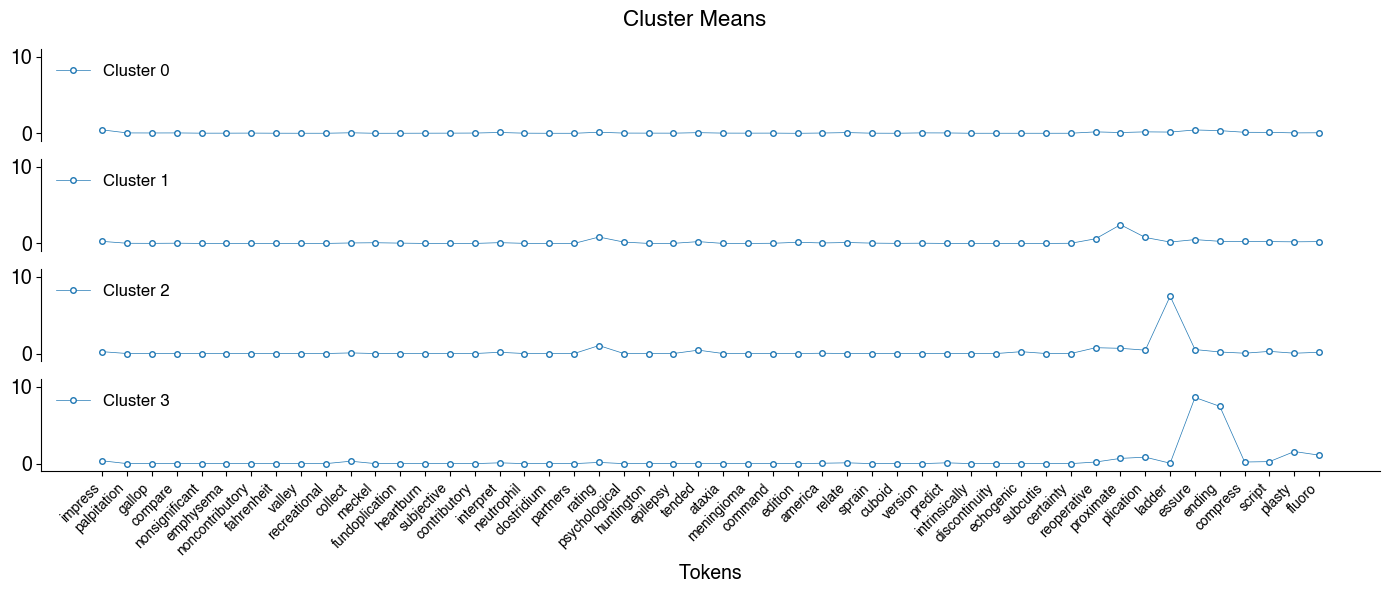

In [16]:
fig = plt.figure(figsize=(14, 6))
# Add subplot
for _k in range(k):
    ax = fig.add_subplot(4, 1, _k + 1)
    ax.plot(cm[-1][_k], lw=0.5, marker='o', markersize=4, markerfacecolor='white',
            label=f"Cluster {_k}")
    ax.set_ylim(-1, 11)
    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha='right')
    ax.tick_params(axis='y', which='major', labelsize=14)
    ax.legend(loc=2, frameon=False, fontsize=12, ncols=4)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if _k < k - 1:
        ax.set_xticks([])
        ax.spines['bottom'].set_visible(False)
    else:
        ax.set_xlabel("Tokens", fontsize=14)
        ax.tick_params(axis='x', which='major', labelsize=10)
plt.suptitle("Cluster Means", fontsize=16)
plt.tight_layout()

The above plot shows the plot of the cluster means (50-vectors) for each of the four clusters. We can make the following observations from the above plots:
1. The mean value is close to 0 for Cluster 0. This means that the tokens we have used in our problem do not appear in most of the reports. These are probably not the best tokens we could have used for this problem.
2. A similar observation can be made for Cluster 1 as well, except for the slightly higher counts for tokens `rating` and `proximate`; there are slight bumps in the curves at these two locations.
3. Cluster 2 and 3 too have zero values for most tokens, except for one or two selected tokens.
4. Cluster 2 has larger value for the token `ladder` and that essentially separates it from the other clusters.
5. Cluster 3 has larger values for the tokens `essure` and `ending` which separate it from the other clusters.


---
### Assignment 01:

1. Its possible that the results we have obtained is due to the choice of the random initialization of the cluster means; another set of random initial values could have resulted in very different clusters from the k-means algorithm. To mitigate this issue, the k-means is often run multiple times with different initial values for the cluster means  to look at the resulting cluster. You are required to run the k-mean algorithm for different seed values (e.g. 10 random values). You can randomly choose some seed values, and fit the k-means model, generate the cluster summary and see the type of clusters identified for each random seeed value. Do you see very different clusters arise each time? Based on these results, what suggestions do you have for improving the clustering performance for this application?

2. We chose the number of clusters $k$ to be four because the dataset we used for this case study had reports from four medical specialities. You can try different values of $k$ and see what kind of cluster you get.